## imports and utility functions

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as lr
import tensorflow as tf
import pickle
import os
import datetime
import matplotlib.pyplot as plt
import math
import copy

rng = np.random.default_rng()

In [3]:
def save_python_object(obj, path, date=True):
    if date:
        with open(path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), "wb") as fp:
            pickle.dump(obj, fp)
    else:
        with open(path, "wb") as fp:
            pickle.dump(obj, fp)
    

def load_python_object(path):
    with open(path, "rb") as fp:
        return pickle.load(fp)

def save_dataset(dataset, name):
    path = os.path.join('../datasets', name)
    tf.data.experimental.save(dataset, path)

def load_dataset(name, input_window_size, already_batched=True):
    path = os.path.join('../datasets', name)
    if already_batched:
        tensor_spec = (tf.TensorSpec(shape=(None, input_window_size, 1), dtype=tf.float64), tf.TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))
    else:
        tensor_spec = (tf.TensorSpec(shape=(input_window_size, 1), dtype=tf.float64), tf.TensorSpec(shape=(1), dtype=tf.float64, name=None))        
    return tf.data.experimental.load(path, element_spec=tensor_spec)

def save_model(model, path):
    model.save(path)

def load_model(path):
    return tf.keras.models.load_model(path)

## training time series generation

In [4]:
def normal_form_saddle_node(t, y, h0, hd, r):
    return h0 + t*hd + r*y - np.power(y, 3)

In [5]:
def spruce_budworm(t, y, r0, rd, Q):
    return y*((r0 + t * rd)*(1 - y/Q) - y/(1 + y**2))

In [6]:
def constant_harvesting(t, y, r, K, h0, hd):
    return r * y * (1 - y/K) - (h0 + t * hd)

In [7]:
def determine_bifu_param_value_normal(r):
    return 2/3*r * np.sqrt(r/3)

In [8]:
def determine_bifu_param_value_spruce(den=10000):
    
    params_upper = np.zeros((den, 3))
    u_upper = np.linspace(1.035, np.sqrt(3), den)
    for i, u in enumerate(u_upper):
        Q = 2*u**3/(u**2 - 1)
        r = 2*u**3/((1+u**2)**2)
        params_upper[i] = u, Q, r
    
    upper_fit = np.poly1d(np.polyfit(params_upper[:,1], params_upper[:,2], 8))
    
    params_lower = np.zeros((den, 3))
    u_lower = np.linspace(np.sqrt(3), np.sqrt(3)*9, den)
    for i, u in enumerate(u_lower):
        Q = 2*u**3/(u**2 - 1)
        r = 2*u**3/((1+u**2)**2)
        params_lower[i] = u, Q, r
    
    lower_fit = np.poly1d(np.polyfit(params_lower[:,1], params_lower[:,2], 6))
    
    Q_ = np.linspace(5.3, 30, den)
    params = np.zeros((den, 3))
    
    for i, Q in enumerate(Q_):
        params[i] = Q, lower_fit(Q), upper_fit(Q)

    return params

In [9]:
def determine_bifu_param_value_constant(r, K):
    return r * K/4

In [10]:
def euler_maruyama(model, y0, dt, t_max, sd, ecological_boundary=False, early_stopping=True, **params):
    n_steps = int(t_max // dt + 1)
    y = np.zeros((n_steps))
    y[0] = y0
    dt_sqrt = np.sqrt(dt)
    
    if ecological_boundary:
        for i in range(1, n_steps):
            t = i * dt
            y[i] = np.maximum(y[i-1] + model(t, y[i-1], **params) * dt + np.random.normal(0, dt_sqrt) * sd, 0.0001)
    else:
        if early_stopping:
            for i in range(1, n_steps):
                t = i * dt
                y[i] = y[i-1] + model(t, y[i-1], **params) * dt + np.random.normal(0, dt_sqrt) * sd
                if y[i] * y[i-1] < 0:
                    y[i:] = -np.mean(y[:i])
                    break
        else:
            for i in range(1, n_steps):
                t = i * dt
                y[i] = y[i-1] + model(t, y[i-1], **params) * dt + np.random.normal(0, dt_sqrt) * sd
        
    return y[::int(1/dt)]

In [11]:
def generate_time_series_normal(n_runs, early_stopping=True):
    y_series = []
    direc = True
    
    while (len(y_series) < n_runs):
    
        r = rng.uniform(2, 10)
        t_max = int(rng.uniform(200, 400))
        sd = rng.uniform(0.2, 0.5)

        direc = not direc

        if direc: # true -> up
            h_bifu = determine_bifu_param_value_normal(r)
            h_start = rng.uniform(h_bifu - 6, h_bifu - 2)
            h_end = h_bifu + 1
            y0 = euler_maruyama(normal_form_saddle_node, y0=-10, dt=0.001, t_max=10, sd=0, ecological_boundary=False, early_stopping=False, h0=h_start, hd=0, r=r)[-1]
        else: # false -> down
            h_bifu = -determine_bifu_param_value_normal(r)
            h_start = rng.uniform(h_bifu + 2, h_bifu + 6)
            h_end = h_bifu - 1
            y0 = euler_maruyama(normal_form_saddle_node, y0=10, dt=0.001, t_max=10, sd=0, ecological_boundary=False, early_stopping=False, h0=h_start, hd=0, r=r)[-1]

        h_step = (h_end - h_start) / t_max
        
        y_series.append(euler_maruyama(normal_form_saddle_node, y0=y0, dt=0.01, t_max=t_max, sd=sd, ecological_boundary=False, early_stopping=early_stopping, h0=h_start, hd=h_step, r=r))
            
    return y_series

In [12]:
def generate_time_series_spruce(n_runs):

    y_series = []
    params = determine_bifu_param_value_spruce()
    
    while (len(y_series) < n_runs):
    
        i = int(rng.uniform(4/20*len(params), len(params)))
        Q = params[i,0]
        t_max = int(rng.uniform(200, 400))
        sd = rng.uniform(0.2, 0.6)

        r_max = params[i,2]
        r_start = rng.uniform(r_max - 0.5, r_max - 0.25)
        r_end = r_max + 0.2
        y0 = euler_maruyama(spruce_budworm, y0=0.1, dt=0.001, t_max=10, sd=0, ecological_boundary=True, r0=r_start, rd=0, Q=Q)[-1]
        
        r_step = (r_end - r_start) / t_max
    
        y_series.append(euler_maruyama(spruce_budworm, y0=y0, dt=0.01, t_max=t_max, sd=sd, ecological_boundary=True, early_stopping=True, r0=r_start, rd=r_step, Q=Q))
 
    return y_series

In [13]:
def generate_time_series_constant(n_runs):
    
    y_series = []
    
    while (len(y_series) < n_runs):
        
        r = rng.uniform(0.5, 10)
        K = rng.uniform(2.5, 10)
        t_max = int(rng.uniform(200, 400))
        sd = rng.uniform(0.1, 0.5)
        
        h_max = determine_bifu_param_value_constant(r, K)
        h_start = rng.uniform(0.5*h_max, 0.8*h_max)
        h_end = 1.2 * h_max
        y0 = euler_maruyama(constant_harvesting, y0=K/2, dt=0.001, t_max=10, sd=0, ecological_boundary=True, r=r, K=K, h0=h_start, hd=0)[-1]
        
        h_step = (h_end - h_start) / t_max
        
        y_series.append(euler_maruyama(constant_harvesting, y0=y0, dt=0.01, t_max=t_max, sd=sd, ecological_boundary=True, early_stopping=True, r=r, K=K, h0=h_start, hd=h_step))

    return y_series

## preprocessing

In [14]:
def smooth(s, window=10, center=True, weighting=None):
    if weighting == None:
        return np.asarray(pd.DataFrame(s).rolling(window=window, min_periods=1, center=center, win_type=weighting).mean())
    elif weighting == 'gaussian':
        return np.asarray(pd.DataFrame(s).rolling(window=window, min_periods=1, center=center, win_type=weighting).mean(std=window/2))      

In [15]:
def linear_partition(s, boundary=0.2):
    
    min_error = 1e9
    shift_loc = -1
    best_pre = lr()
    best_post = lr()
    best_pre_X = None
    best_post_X = None
    
    for i in range(int(boundary*len(s)), int((1-boundary)*len(s))):
        pre = s[:i]
        pre_X = np.reshape([x for x in range(0, len(pre))], (len(pre), 1))
        pre_fit = lr().fit(X=pre_X, y=pre)
        pre_pred = pre_fit.predict(pre_X)
        pre_error = np.sqrt(sum((pre_pred - pre)**2))
        
        post = s[i:]
        post_X = np.reshape([x for x in range(i, i+len(post))], (len(post), 1))
        post_fit = lr().fit(X=post_X, y=post)
        post_pred = post_fit.predict(post_X)
        post_error = np.sqrt(sum((post_pred - post)**2))
        
        error = (pre_error * len(pre_X) + post_error * len(post_X))/len(s)
        
        if (error < min_error):
            min_error = error
            shift_loc = i
            best_pre = pre_fit
            best_pre_X = pre_X
            best_post = post_fit
            best_post_X = post_X
        
    shift_value = abs(best_pre.predict(np.asarray([shift_loc]).reshape(-1,1)) - best_post.predict(np.asarray([shift_loc]).reshape(-1,1)))[0]
    
    return shift_value/min_error, best_pre_X[-1][0]

In [16]:
def shift_scores_loc(s):
    shift_score = np.zeros((len(s)))
    shift_loc = np.zeros((len(s)))
    for i, run in enumerate(s):
        shift_score[i], shift_loc[i] = linear_partition(run, boundary=0.1)
    
    return shift_score, shift_loc

In [17]:
def remove_outliers(series, scores, locs, score_threshold, loc_boundary):
    quality_series = []
    shift_scores = []
    shift_locs = []
    removed_count = 0
    for s, score, loc in zip(series, scores, locs):
        rel_shift_loc = loc/len(s)
        if score > score_threshold and (rel_shift_loc > loc_boundary and rel_shift_loc < 1 - loc_boundary):
            quality_series.append(s)
            shift_scores.append(score)
            shift_locs.append(loc)
        else:
            removed_count += 1
    
    print(removed_count, "series have been removed.", len(quality_series), "well behaved series remaining.")
    return quality_series, shift_scores, shift_locs

In [18]:
def normalize_series(series, shift_locs):
    n_series = []
    for s, loc in zip(series, shift_locs):
        loc = int(loc)
        s_mean = np.mean(s[:loc+1])
        s_sd = np.std(s[:loc+1])
        n_series.append((s-s_mean)/s_sd)
    return n_series

## TensorFlow dataset generation

In [19]:
def multiple_series_into_dataset(series, shift_locs, shift_gap, input_window_size, transition_phase, saturation_phase, oversampling = False):
    
    dataset = one_series_into_dataset(series[0], shift_locs[0], shift_gap, input_window_size, transition_phase, saturation_phase, oversampling)
   
    for s, loc in zip(series[1:], shift_locs[1:]):
        ds = one_series_into_dataset(s, loc, shift_gap, input_window_size, transition_phase, saturation_phase, oversampling)
        if ds != None:
            dataset = dataset.concatenate(ds)
        
    return dataset

In [20]:
def one_series_into_dataset(s, shift_loc, shift_gap=3, input_window_size=20, transition_phase=30, saturation_phase=10, oversampling = False):

    shift_loc = int(shift_loc)
    s = s[:shift_loc-shift_gap]
    
    n_windows = len(s) - input_window_size + 1
    
    while (n_windows < transition_phase + saturation_phase):
        transition_phase = max(transition_phase - 1, 2)
        saturation_phase = max(saturation_phase - 1, 2)
        print(saturation_phase, transition_phase)
        if transition_phase == 2:
            return None
              
    data = np.zeros((n_windows, input_window_size))
    for i in range(n_windows):
        data[i,:] = s[i:i+input_window_size]

    label = np.zeros((n_windows))
    label_transition = 1 / (1 + np.e**(0.5*30/transition_phase*(-np.linspace(0,transition_phase,transition_phase, endpoint=True)+transition_phase/2)))
    label[-transition_phase-saturation_phase+1:-saturation_phase+1] = label_transition
    if (saturation_phase > 0):
        label[-saturation_phase:] = 1
        
    dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(tf.convert_to_tensor(data), axis=2), tf.expand_dims(tf.convert_to_tensor(label), axis=1)))
    
    if oversampling:
        shift_data = data[label != 0]
        shift_label = label[label != 0]

        shift_len = transition_phase + saturation_phase
        no_shift_len = n_windows - shift_len

        while (len(shift_data) < no_shift_len - shift_len):
            shift_data = np.append(shift_data, data[label != 0], axis=0)
            shift_label = np.append(shift_label, label[label != 0], axis=0)

        shift_data = shift_data[:no_shift_len-shift_len]
        shift_label = shift_label[:no_shift_len-shift_len]

        dataset_to_balance_shift = tf.data.Dataset.from_tensor_slices((tf.expand_dims(tf.convert_to_tensor(shift_data), axis=2), tf.expand_dims(tf.convert_to_tensor(shift_label), axis=1)))
        dataset = dataset.concatenate(dataset_to_balance_shift)
    
    return dataset

#n=3
#one_series_into_dataset(y_series_normal[n], shift_loc_normal[n], shift_gap=7, transition_phase=50)
# normal 1
# constant 3
# spruce 7

In [21]:
def merge_datasets(datasets):
    if len(datasets) >= 2:
        d = datasets[0]
        for d_another in datasets[1:]:
            d = d.concatenate(d_another)
            
        return d

## validation data

In [22]:
def recruitment(y, r, sd=0.02):
    return np.maximum(y * np.exp(r * (1 - y)) + np.random.normal(0,sd), 0)
def mortality(y, a, sd=0.02):
    return np.maximum(y * np.exp(-a * y) + np.random.normal(0,sd), 0)
def harvesting(y, h, sd=0.02):
    return np.maximum((1 - h) * y + np.random.normal(0,sd), 0)
def MHR(y, r, a, h, sd=0.02):
    return recruitment(harvesting(mortality(y, a, sd), h, sd), r, sd)

def get_bifurcation_diagram_data(model, y0s, bifurcation_param, warm_up=100, sample_iter=15, **params):
    
    bifu_data = np.zeros((len(params.get(bifurcation_param)), len(y0s), sample_iter))
    
    for i, y0 in enumerate(y0s):
        y = y0
        for _ in range(warm_up):
            y = model(y, **params)
        for t in range(sample_iter):
            y = model(y, **params)
            bifu_data[:, i, t] = y
                
    return bifu_data

# function which assesses the data of the bifurcation diagram to find parameter value pairs which exhibit
# sudden shifts and locate the value of the bifurcation parameter for which these shifts are occuring
def suitable_initial_parameter(model, y0s, bifurcation_param, warm_up=100, sample_iter=15, **params):
    
    # get the data from the bifurcation diagram function
    bifu_data = get_bifurcation_diagram_data(model, y0s, bifurcation_param, warm_up=warm_up, sample_iter=sample_iter, **params)
    bifu_data = bifu_data[:,0,:]
    bifu_steps = bifu_data.shape[0]
    bifu_param = params.get(bifurcation_param)
    
    # calc the mean and standard deviation (of the population size over all timesteps) for each value 
    # of the bifurcation parameter
    mean_val = bifu_data.mean(axis=1)
    std_val = bifu_data.std(axis=1)
    
    # if the standard deviation is sufficiently low the point is considered stable
    stable_bifu_param = (std_val < 0.2) * 1.0
    
    # if the values are cycling around the mean (2-cycle) this can also be detected
    for i in range(bifu_steps):
        if (stable_bifu_param[i] == 0) and abs(bifu_data[i] - mean_val[i]).std() < 0.2:
            stable_bifu_param[i] = 0.5
    
    # the stability categorization can be smoothed to eliminate small errors / outliers
    stable_bifu_param = smooth(stable_bifu_param, window=5)
    
    jump_val = np.zeros((bifu_steps))
    suitable_bifu_param = None
    suitable_y0 = None
    
    for i in range(bifu_steps-1):
        # if two consecutive points are sufficiently stable
        if stable_bifu_param[i]>0.7 and stable_bifu_param[i+1] > 0.3:
            # and the relative mean difference is sufficiently large, a jump value can be calculated
            jump_val[i] = abs(mean_val[i] - mean_val[i+1]) / max(mean_val[i], mean_val[i+1])# / max(std_val[i], std_val[i+1], 1)# / max(mean_val[i], mean_val[i+1])
            # and the position can be marked as shift (and a suitable starting point for the bifurcation 
            # parameter) if the jump is large enough
            if (jump_val[i] > 1/3):
                suitable_bifu_param = bifu_param[i]
                suitable_y0 = mean_val[i]
    
    return suitable_bifu_param, suitable_y0

In [23]:
def generate_time_series_MHR(n_runs, sd, both_direction=True):
    y_series = []

    timesteps = 400
    sd = sd
    
    success = True
    direction = True # -> up

    while (len(y_series) < n_runs):
        
        if success and both_direction:
            direction = not direction
        
        success = False
        
        # generate random model parameter in a promising region of the parameter space
        a = rng.uniform(0.3, 0.5, 1)[0]
        r = rng.uniform(3, 6, 1)[0]

        # check whether the bifurcation diagram, given the model parameters, suggests a shift and if yes for which value
        # of the bifurcation parameter
        if direction:
            h, y0 = suitable_initial_parameter(model=MHR, y0s=[2, 12], bifurcation_param='h', r=r, a=a, h=np.linspace(0, 0.9, 700, endpoint=True), sd=0)
        else:
            h, y0 = suitable_initial_parameter(model=MHR, y0s=[12, 2], bifurcation_param='h', r=r, a=a, h=np.linspace(0, 0.9, 700, endpoint=True), sd=0)
        if h != None:
            rnd_delta = rng.uniform(0.05, 0.2, 1)[0]
            y = 0
            if direction:
                h = h-rnd_delta
                y = y0
            else:
                h = h+rnd_delta
                y = y0+9
            ys = np.zeros(timesteps)
            
            for n in range(timesteps):
                y = MHR(y, r=r, a=a, h=h, sd=sd)
                ys[n] = y
                if direction:
                    h += (2*rnd_delta/timesteps)
                else:
                    h -= (2*rnd_delta/timesteps)

            score, _ = linear_partition(ys)
            if score > 0.5:
                y_series.append(ys[5:])
                success = True
                
    return y_series

## CSD indicators / classical approach

In [24]:
def detrend(s, detrend_window, center=True):
    return s - smooth(s, window=detrend_window, weighting='gaussian', center=center)[:,0]

In [25]:
def CSD_indicators(s, shift_loc, input_window_size, detrend_window, latest_detection_point, draw=False):
    
    shift_loc = int(shift_loc)
    
    if draw:
        plt.plot((s[:shift_loc+20]-min(s[:shift_loc+20]))/(max(s[:shift_loc+20])-min(s[:shift_loc+20])), label='time series')
        plt.plot(shift_loc, (s[shift_loc]-min(s[:shift_loc+20]))/(max(s[:shift_loc+20])-min(s[:shift_loc+20])), "or", ms=9, label="shift location")

    s = normalize_series([s], [shift_loc])[0]
    
    s = s[:shift_loc-latest_detection_point]
    
    # gaussian windowed detrending of Dakos2015
    s = detrend(s, detrend_window, center=True)
    
    sd = [np.nan] * input_window_size
    AR1 = [np.nan] * input_window_size
    
    for i in range(input_window_size, len(s)):
        sd.append(np.std(s[i-input_window_size:i]))
        #plt.scatter(s[i-input_window_size:i], s[i-input_window_size+1:i+1])
        AR1.append(abs(np.corrcoef(s[i-input_window_size:i], s[i-input_window_size+1:i+1])[0,1]))
        
    if draw:
        #plt.plot((s-min(s))/(max(s)-min(s)))
        plt.plot([sd_scale*6 for sd_scale in sd], label='sd (x5)') 
        plt.plot(AR1, label='AR1')
        #plt.plot([(0.5*s+0.5*a) for s,a in zip(sd, AR1)])
        plt.legend()
        plt.xlabel("time steps")
        plt.ylabel("indicator strength")
        #plt.savefig(fname='../graphs/CSD_indicators.pdf', format='pdf')
    
    return sd, AR1
    
        
#CSD_indicators([0,1,2,3,4,5,6,7,8,9,20,21,22,23,24,25,26,27,28,29], 3)
n=14 # 8, 14, 42, 54. 74
#sd, AR1 = CSD_indicators(s=y_series_MHR[n], shift_loc=shift_loc_MHR[n], input_window_size=50, detrend_window=50, latest_detection_point=10, draw=True)

In [55]:
def classify_CSD_response(timeseries, shift_loc, input_window_size, detrend_window, latest_detection_point=10, earliest_detection_point=30):
    
    no_shift_CSD_response = []
    shift_CSD_response = []
    
    for s, s_loc in zip(timeseries, shift_loc):
        sd, AR1 = CSD_indicators(s, s_loc, input_window_size, detrend_window, latest_detection_point)
        response = [(0.5*min(s,5)+0.5*a) for s,a in zip(sd, AR1)]
        
        if not all(np.isnan(response[:-(earliest_detection_point-latest_detection_point)])):
            no_shift_CSD_response.append(np.nanmax(response[:-(earliest_detection_point-latest_detection_point)]))
            shift_CSD_response.append(np.nanmax(response[-(earliest_detection_point-latest_detection_point):]))
        
    return no_shift_CSD_response, shift_CSD_response
        
no_shift_CSD_response, shift_CSD_response = classify_CSD_response(timeseries=y_series_MHR_cleaned, shift_loc=shift_loc_MHR_c, input_window_size=50, detrend_window=50)

In [ ]:
#no_shift_CSD_response, shift_CSD_response = classify_CSD_response(timeseries=y_series_MHR_cleaned, shift_loc=shift_loc_MHR_c, input_window_size=50, detrend_window=50)
# without normalizing
optimal threshold: 0.3783766298619862
optimal score: 0.6655886157826635
    
optimal threshold: 0.09686944142526463
optimal score: 0.5151515151515151
chosen threshold: 0.3784670625505606
score of chosen threshold: 0.48989898989898994

In [ ]:
# with normalizing
optimal threshold: 0.42004435447604016
optimal score: 0.6826218197498916
    
optimal threshold: 0.5934762075324966
optimal score: 0.590909090909091
chosen threshold: 0.420078549552446
score of chosen threshold: 0.5303030303030303

optimal threshold: 0.42004435447604016
optimal score: 0.6826218197498916


(0.42004435447604016, 0.6826218197498916)

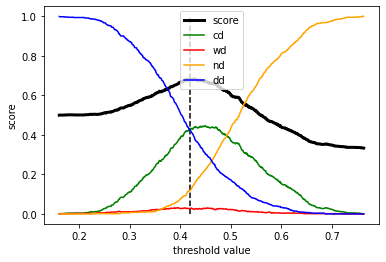

In [63]:
no_shift_CSD_response, shift_CSD_response = classify_CSD_response(timeseries=y_series_MHR_cleaned, shift_loc=shift_loc_MHR_c, input_window_size=50, detrend_window=50)
determine_threshold(no_shift_CSD_response, shift_CSD_response)

optimal threshold: 0.5934762075324966
optimal score: 0.590909090909091
chosen threshold: 0.420078549552446
score of chosen threshold: 0.5303030303030303


(0.5934762075324966, 0.590909090909091)

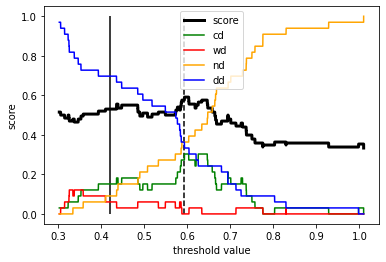

In [64]:
no_shift_CSD_response, shift_CSD_response = classify_CSD_response(timeseries=empirical_timeseries_ending_shift, shift_loc=empirical_timeseries_ending_shift_loc, input_window_size=50, detrend_window=50)
determine_threshold(no_shift_CSD_response, shift_CSD_response, chosen_threshold=0.42004435447604016, threshold_density=10000)

In [71]:
def false_positive_test_CSD(timeseries, input_window_size, detrend_window, chosen_threshold, latest_detection_point=0):
    false_positive = 0
    for s in timeseries:
        sd, AR1 = CSD_indicators(s, len(s), input_window_size, detrend_window, latest_detection_point)
        
        response = [(0.5*s+0.5*a) for s,a in zip(sd, AR1)]
        
        print(np.nanmax(response[:]))
        
        if np.nanmax(response[:]) > chosen_threshold:
            false_positive += 1
        
    return 1 - (false_positive/len(timeseries))

false_positive_test_CSD(empirical_timeseries_no_shift, 50, 50, 0.42004435447604016)

0.5678361290420707
0.53634147484018
0.6518468104155802
0.5377613687374436
0.5603866570943451
0.7048384580729158
0.7023778307172124
0.6463229039226225
0.64142128834813
0.8713471997996234
0.861313999284824
0.6590584727696129
0.6113359488839962
0.7447981946766437
0.6083780666715577
0.6316197680722507
0.6191707009559466
0.628637359187877
0.6745712992729893
0.729560201621856
0.5810184838424218


0.0

## Neural network creation/training

In [15]:
def create_LSTM_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
    model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))

    
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.005,
        decay_steps=100,
        decay_rate=0.90,
        staircase=True)
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
    loss = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(optimizer, loss)
    
    return model

def train_LSTM_model(tag_base, train_data, val_data, history_dict, input_window_size, steps_per_epoch=20, patience=30, batch_size=32, runs=1): 
    best_fit_model = None
    best_fit_tag = None
    for _ in range(runs):
        LSTM_model = create_LSTM_model()

        tag = tag_base + '__' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

        callbacks = [
                tf.keras.callbacks.TensorBoard(
                    log_dir="logs/thesis/" + tag,
                    update_freq=100
                ),
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    min_delta=0.001,
                    patience=patience,
                    mode='min',
                    baseline=0.29, #0.24
                    restore_best_weights=True
                )
            ]
        
        td = train_data.shuffle(buffer_size=np.array(train_data.cardinality()))
        td = td.batch(batch_size)
        td = td.repeat(-1)
        
        vd = val_data.batch(1024)

        history_dict[tag] = LSTM_model.fit(x=td, steps_per_epoch=steps_per_epoch, epochs=2000, validation_data=vd, callbacks=callbacks).history
        
        no_shift_response, shift_response = classify_model_response([LSTM_model], [input_window_size], y_series_MHR_cleaned[:99], shift_loc_MHR_c[:99])
        thres, score = determine_threshold(no_shift_response, shift_response, threshold_density=100, draw=False)
        history_dict[tag]['threshold'] = thres
        history_dict[tag]['score'] = score
        
        if best_fit_model == None:
            best_fit_model = LSTM_model
            best_fit_tag = tag
        else:
            if min(history_dict[best_fit_tag]['val_loss']) > min(history_dict[tag]['val_loss']):
                best_fit_model = LSTM_model
                best_fit_tag = tag
        
    return best_fit_model

## Empirical data

In [26]:
def get_empirical_data():

    d1 = pd.read_csv(filepath_or_buffer="../empirical_data/Hennekam-etal_2020/datasets/64PE406-E1_calibratedXRF.tab",
                    delimiter='\t',
                    header=18)

    d2 = pd.read_csv(filepath_or_buffer="../empirical_data/Hennekam-etal_2020/datasets/MS21PC_calibratedXRF.tab",
                    delimiter='\t',
                    header=19)

    d3 = pd.read_csv(filepath_or_buffer="../empirical_data/Hennekam-etal_2020/datasets/MS66PC_calibratedXRF.tab",
                    delimiter='\t',
                    header=19)

    d1 = d1.iloc[::-1]
    d2 = d2.iloc[::-1]
    d3 = d3.iloc[::-1]

    sediment_1_Mo = list(d1['Mo [mg/kg]'])
    sediment_1_Ba = list(d1['Ba [mg/kg]'])
    sediment_1_U = list(d1['U [mg/kg]'])

    sediment_2_Mo = list(d2['Mo [mg/kg]'])

    sediment_3_Al = list(d3['Al [mg/kg]'])
    sediment_3_Mo = list(d3['Mo [mg/kg]'])
    sediment_3_Ti = list(d3['Ti [mg/kg]'])
    sediment_3_U = list(d3['U [mg/kg]'])

    rss_sediment_1_Ba = [sediment_1_Ba[0:208], sediment_1_Ba[900:1126], sediment_1_Ba[3064:3264], sediment_1_Ba[4700:4945],
                        sediment_1_Ba[5600:5783], sediment_1_Ba[7472:7666]]
    rss_sediment_1_Mo = [sediment_1_Mo[900:1141], sediment_1_Mo[1200:1489], sediment_1_Mo[1840:2045], sediment_1_Mo[2420:2621],
                        sediment_1_Mo[3870:4043], sediment_1_Mo[4760:4963], sediment_1_Mo[5600:5799]]
    rss_sediment_1_U = [sediment_1_U[920:1129], sediment_1_U[1800:2031], sediment_1_U[3900:4045], sediment_1_U[4700:4948],
                        sediment_1_U[5580:5784]]

    rss_sediment_2_Mo = [sediment_2_Mo[720:923], sediment_2_Mo[2740:2940], sediment_2_Mo[6380:6579]]

    rss_sediment_3_Mo = [sediment_3_Mo[1400:1621], sediment_3_Mo[2200:2447]]

    rss_sediment_3_U = [sediment_3_U[2240:2448]]

    rss_sediment_3_Ti = [sediment_3_Ti[300:511], sediment_3_Ti[4250:4466]]

    rss_sediment_3_Al = [sediment_3_Al[300:511]]

    d_alley1 = pd.read_csv(filepath_or_buffer="../empirical_data/gisp2_temp_accum_alley2000.txt",
                    delimiter='\s+',
                    header=52,
                    nrows=1632,
                    encoding='cp1252')

    d_alley2 = pd.read_csv(filepath_or_buffer="../empirical_data/gisp2_temp_accum_alley2000.txt",
                    delimiter='\s+',
                    header=1688,
                    nrows=1700,
                    encoding='cp1252')

    d_cariaco = pd.read_csv(filepath_or_buffer="../empirical_data/cariaco2000_pc56_greyscale.txt",
                    delimiter='\s+',
                    header=0,
                    nrows=10424,
                    encoding='cp1252')

    d_cariaco = d_cariaco.iloc[::-1]

    cariaco = list(d_cariaco['Cariaco_grey_scale_(0-255)'])

    d_deut = pd.read_csv(filepath_or_buffer="../empirical_data/deutnat.txt",
                    delimiter='\s+',
                    header=84,
                    nrows=10424,
                    encoding='cp1252')

    d_deut = d_deut.iloc[::-1]

    deut = list(d_deut['deut'])

    d_geochem = pd.read_csv(filepath_or_buffer='../empirical_data/PASSAP_PS009PC_geochem.tab',
                    delimiter='\t',
                    header=15)

    d_geochem['Ba/Al'][315] = 0.00195
    d_geochem['Ba/Al'][349] = 0.00205
    d_geochem['Ba/Al'][353] = 0.00207

    geo_chem_Ba = list(d_geochem['Ba/Al'])

    d_geochem['V/Al'][315] = 0.00164
    d_geochem['V/Al'][349] = 0.001535
    d_geochem['V/Al'][353] = 0.00152

    geo_chem_V = list(d_geochem['V/Al'])

    rss = []
    rss.extend(rss_sediment_1_Ba)
    rss.extend(rss_sediment_1_Mo)
    rss.extend(rss_sediment_1_U)
    rss.extend(rss_sediment_2_Mo)
    rss.extend(rss_sediment_3_Mo)
    rss.extend(rss_sediment_3_U)
    rss.extend(rss_sediment_3_Ti)
    rss.extend(rss_sediment_3_Al)

    rss.append(list(d_alley1['Temperature(C)'][0:878]))
    rss.append(list(d_alley2['Accumulation'][0:400]))

    rss.append(cariaco[4750:5065])

    rss.append(deut[1200:1386])

    rss.append(geo_chem_Ba[170:384])
    rss.append(geo_chem_V[200:405])

    rss_loc = [len(s) for s in rss]
    
    
    fpt_sediment_1_Mo = [sediment_1_Mo[0:200],sediment_1_Mo[200:400],sediment_1_Mo[400:600],sediment_1_Mo[600:800],
                         sediment_1_Mo[3000:3200],sediment_1_Mo[3200:3400],sediment_1_Mo[3400:3600],
                         sediment_1_Mo[3500:3700]]
    
    fpt_sediment_1_Ba = [sediment_1_Ba[300:500],sediment_1_Ba[500:700],sediment_1_Ba[600:800],sediment_1_Ba[3500:3700],
                         sediment_1_Ba[3700:3900]]
    
    fpt_sediment_1_U = [sediment_1_U[0:200],sediment_1_U[200:400],sediment_1_U[400:600],sediment_1_U[600:800],
                        sediment_1_U[3000:3200],sediment_1_U[3200:3400],sediment_1_U[3400:3600],sediment_1_U[3600:3800]]
    
    fpt = []
    fpt.extend(fpt_sediment_1_Ba)
    fpt.extend(fpt_sediment_1_Mo)
    fpt.extend(fpt_sediment_1_U)
    
    return rss, rss_loc, fpt

## Evaluation

In [64]:
def classify_model_response(models, input_window_sizes, timeseries, shift_loc, latest_detection_point=10, earliest_detection_point=30):
    
    no_shift_response = []
    shift_response = []
    
    for s, s_loc in zip(timeseries, shift_loc):
        s = normalize_series([s], [s_loc])[0]
        
        s_loc = int(s_loc)
        s = s[:s_loc-latest_detection_point]
        
        model_pred = [[] for _ in range(len(models))]
        for n, model in enumerate(models):
            for i in range(0, len(s)):
                if i < input_window_sizes[n]:
                    model_pred[n].append(np.nan)
                else:
                    model_pred[n].append(np.array(model(s[i-input_window_sizes[n]:i].reshape((1, input_window_sizes[n], 1))))[0,0])
        
        model_pred_avg = np.mean(model_pred, axis=0)
        
        no_shift_response.append(np.nanmax(model_pred_avg[:-(earliest_detection_point-latest_detection_point)]))
        shift_response.append(np.nanmax(model_pred_avg[-(earliest_detection_point-latest_detection_point):]))
        
    return no_shift_response, shift_response

In [ ]:
def determine_threshold(no_shift_response, shift_response, chosen_threshold=None, threshold_density=1000, draw=True):
    correct_discrimation = []
    wrong_discrimination = []
    no_detection = []
    double_detection = []
    score = []
    
    threshold_range = np.linspace(min(min(no_shift_response), min(shift_response)), max(max(no_shift_response), max(shift_response)), threshold_density, endpoint=True)
    for t in threshold_range:
        cd = 0
        wd = 0
        nd = 0
        dd = 0
        s = 0
        for val_no_shift, val_shift in zip(no_shift_response, shift_response):
            if t < val_shift:
                if val_no_shift <= t:
                    cd += 1
                    s += 1
                else:
                    dd += 1
                    s += 1/2
            else:
                if val_no_shift <= t:
                    nd += 1
                    s += 1/3
                else:
                    wd += 1
                    s += 0
        
        correct_discrimation.append(cd/len(shift_response))
        wrong_discrimination.append(wd/len(shift_response))
        no_detection.append(nd/len(shift_response))
        double_detection.append(dd/len(shift_response))
        score.append(s/len(shift_response))
    
    if draw:
        plt.plot(threshold_range, score, label='score', lw=3, c='k')
        plt.plot(threshold_range, correct_discrimation, label='cd', c='g')
        plt.plot(threshold_range, wrong_discrimination, label='wd', c='r')
        plt.plot(threshold_range, no_detection, label='nd', c='orange')
        plt.plot(threshold_range, double_detection, label='dd', c='b')
        plt.vlines(x=threshold_range[np.argmax(score)], ymin=0, ymax=1, color='k', ls='dashed')
        plt.xlabel("threshold value")
        plt.ylabel("score")
        plt.legend()
        #plt.savefig(fname='../graphs/determine_threshold_smooth.pdf', format='pdf')
        
    
    print("optimal threshold:", threshold_range[np.argmax(score)])
    print("optimal score:", max(score))
    
    if chosen_threshold != None:
        index_chosen_threshold = np.abs(threshold_range - chosen_threshold).argmin()
        print("chosen threshold:", threshold_range[index_chosen_threshold])
        print("score of chosen threshold:", score[index_chosen_threshold])
        plt.vlines(x=threshold_range[index_chosen_threshold], ymin=0, ymax=1, color='k')
    
    return threshold_range[np.argmax(score)], max(score)

In [ ]:
def false_positive_test(models, input_window_sizes, timeseries, chosen_threshold):
    
    false_positive = 0
    for s in timeseries:
        
        s = normalize_series([s], [len(s)])[0]
        
        model_pred = [[] for _ in range(len(models))]
        for n, model in enumerate(models):
            for i in range(0, len(s)):
                if i < input_window_sizes[n]:
                    model_pred[n].append(np.nan)
                else:
                    model_pred[n].append(np.array(model(s[i-input_window_sizes[n]:i].reshape((1, input_window_sizes[n], 1))))[0,0])
        
        model_pred_avg = np.mean(model_pred, axis=0)
        
        if np.nanmax(model_pred_avg[:]) > chosen_threshold:
            false_positive += 1
    
    return 1 - (false_positive/len(timeseries))

## Application

In [45]:
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
y_series_normal = generate_time_series_normal(n_runs=1000, early_stopping=True)
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20211028-175854
20211028-175857


In [21]:
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
y_series_spruce = generate_time_series_spruce(n_runs=500)
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20211018-180441
20211018-180748


In [22]:
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
y_series_constant = generate_time_series_constant(n_runs=500)
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20211018-180748
20211018-181035


In [372]:
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
y_series_MHR = generate_time_series_MHR(800, 0.008)
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20211108-111552
20211108-111738


In [23]:
shift_score_normal, shift_loc_normal = shift_scores_loc(y_series_normal)

In [24]:
shift_score_spruce, shift_loc_spruce = shift_scores_loc(y_series_spruce)

In [25]:
shift_score_constant, shift_loc_constant = shift_scores_loc(y_series_constant)

In [373]:
shift_score_MHR, shift_loc_MHR = shift_scores_loc(y_series_MHR)

In [74]:
y_series_normal_cleaned, shift_score_normal_c, shift_loc_normal_c = remove_outliers(y_series_normal, shift_score_normal, shift_loc_normal, 1, 0.15)
y_series_spruce_cleaned, shift_score_spruce_c, shift_loc_spruce_c = remove_outliers(y_series_spruce, shift_score_spruce, shift_loc_spruce, 0.8, 0.15)
y_series_constant_cleaned, shift_score_constant_c, shift_loc_constant_c = remove_outliers(y_series_constant, shift_score_constant, shift_loc_constant, 0.9, 0.15)

33 series have been removed. 967 well behaved series remaining.
42 series have been removed. 458 well behaved series remaining.
56 series have been removed. 444 well behaved series remaining.


In [52]:
y_series_MHR_cleaned, shift_score_MHR_c, shift_loc_MHR_c = remove_outliers(y_series_MHR, shift_score_MHR, shift_loc_MHR, 0.6, 0.15)

26 series have been removed. 774 well behaved series remaining.


In [75]:
y_series_normal_normalized = normalize_series(y_series_normal_cleaned, shift_loc_normal_c)
y_series_spruce_normalized = normalize_series(y_series_spruce_cleaned, shift_loc_spruce_c)
y_series_constant_normalized = normalize_series(y_series_constant_cleaned, shift_loc_constant_c)

In [34]:
y_series_MHR_normalized = normalize_series(y_series_MHR_cleaned, shift_loc_MHR_c)

In [40]:
dataset_normal_1000 = multiple_series_into_dataset(y_series_normal_normalized, shift_loc_normal_c, shift_gap=1, input_window_size=20, transition_phase=30, saturation_phase=10, oversampling=True)
dataset_spruce_500 = multiple_series_into_dataset(y_series_spruce_normalized, shift_loc_spruce_c, shift_gap=7, input_window_size=20, transition_phase=30, saturation_phase=10, oversampling=True)
dataset_constant_500 = multiple_series_into_dataset(y_series_constant_normalized, shift_loc_constant_c, shift_gap=3, input_window_size=20, transition_phase=30, saturation_phase=10, oversampling=True)

dataset_merge_2000_i20 = merge_datasets([dataset_normal_1000, dataset_spruce_500, dataset_constant_500])

9 29
8 28
7 27
6 26
5 25
4 24
3 23
2 22


In [55]:
dataset_MHR_800_i20 = multiple_series_into_dataset(y_series_MHR_normalized, shift_loc_MHR_c, shift_gap=7, input_window_size=20, transition_phase=30, saturation_phase=10, oversampling=False)

In [16]:
history_i20 = {}
LSTM_model_i20 = train_LSTM_model(tag_base='thesis_i20', train_data=dataset_merge_2000_i20, val_data=dataset_MHR_800_i20, history_dict=history_i20, input_window_size=20, steps_per_epoch=20, patience=30, runs=10)

Epoch 1/2000
20/20 [==============================] - 17s 184ms/step - loss: 0.5352 - val_loss: 0.2965
Epoch 2/2000
20/20 [==============================] - 3s 151ms/step - loss: 0.4753 - val_loss: 0.3306
Epoch 3/2000
20/20 [==============================] - 3s 153ms/step - loss: 0.4505 - val_loss: 0.3594
Epoch 4/2000
20/20 [==============================] - 3s 150ms/step - loss: 0.4623 - val_loss: 0.2938
Epoch 5/2000
20/20 [==============================] - 3s 149ms/step - loss: 0.4798 - val_loss: 0.3085
Epoch 6/2000
20/20 [==============================] - 3s 151ms/step - loss: 0.4210 - val_loss: 0.2795
Epoch 7/2000
20/20 [==============================] - 3s 149ms/step - loss: 0.4326 - val_loss: 0.2768
Epoch 8/2000
20/20 [==============================] - 3s 149ms/step - loss: 0.4109 - val_loss: 0.2698
Epoch 9/2000
20/20 [==============================] - 3s 149ms/step - loss: 0.3999 - val_loss: 0.2913
Epoch 10/2000
20/20 [==============================] - 3s 148ms/step - loss: 0.36

Epoch 31/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3983 - val_loss: 0.2628
Epoch 32/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4292 - val_loss: 0.2521
Epoch 33/2000
20/20 [==============================] - 3s 144ms/step - loss: 0.3863 - val_loss: 0.2563
Epoch 34/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4402 - val_loss: 0.2605
Epoch 35/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4030 - val_loss: 0.2598
Epoch 36/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4186 - val_loss: 0.2713
Epoch 37/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4078 - val_loss: 0.2709
Epoch 38/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4086 - val_loss: 0.2524
Epoch 39/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4048 - val_loss: 0.2519
Epoch 40/2000
20/20 [==============================] - 3s 145ms/step - lo

Epoch 31/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3987 - val_loss: 0.2514
Epoch 32/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3981 - val_loss: 0.2529
Epoch 33/2000
20/20 [==============================] - 3s 144ms/step - loss: 0.3915 - val_loss: 0.2539
Epoch 34/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4310 - val_loss: 0.2727
Epoch 35/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4097 - val_loss: 0.2486
Epoch 36/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3875 - val_loss: 0.2526
Epoch 37/2000
20/20 [==============================] - 3s 144ms/step - loss: 0.3534 - val_loss: 0.2380
Epoch 38/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.3855 - val_loss: 0.2510
Epoch 39/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4048 - val_loss: 0.2748
Epoch 40/2000
20/20 [==============================] - 3s 145ms/step - lo

Epoch 17/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4223 - val_loss: 0.2502
Epoch 18/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4301 - val_loss: 0.2821
Epoch 19/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3759 - val_loss: 0.2449
Epoch 20/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4062 - val_loss: 0.2685
Epoch 21/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4199 - val_loss: 0.2530
Epoch 22/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4438 - val_loss: 0.2758
Epoch 23/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4153 - val_loss: 0.2529
Epoch 24/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4082 - val_loss: 0.2477
Epoch 25/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4027 - val_loss: 0.2585
Epoch 26/2000
20/20 [==============================] - 3s 145ms/step - lo

20/20 [==============================] - 3s 146ms/step - loss: 0.3701 - val_loss: 0.2559
Epoch 34/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4026 - val_loss: 0.2529
Epoch 35/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3974 - val_loss: 0.2482
Epoch 36/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.4360 - val_loss: 0.2790
Epoch 37/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4001 - val_loss: 0.2567
Epoch 38/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4102 - val_loss: 0.2579
Epoch 39/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4201 - val_loss: 0.2819
Epoch 40/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.3642 - val_loss: 0.2329
Epoch 41/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.4001 - val_loss: 0.2539
Epoch 42/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3827 - v

20/20 [==============================] - 3s 145ms/step - loss: 0.4126 - val_loss: 0.2637
Epoch 19/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4122 - val_loss: 0.2663
Epoch 20/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4306 - val_loss: 0.2844
Epoch 21/2000
20/20 [==============================] - 3s 144ms/step - loss: 0.4215 - val_loss: 0.2594
Epoch 22/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4570 - val_loss: 0.2858
Epoch 23/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3771 - val_loss: 0.2584
Epoch 24/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3824 - val_loss: 0.2604
Epoch 25/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4003 - val_loss: 0.2390
Epoch 26/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3922 - val_loss: 0.2635
Epoch 27/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4062 - v

20/20 [==============================] - 3s 146ms/step - loss: 0.4240 - val_loss: 0.2728
Epoch 14/2000
20/20 [==============================] - 3s 144ms/step - loss: 0.4262 - val_loss: 0.2759
Epoch 15/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3924 - val_loss: 0.2575
Epoch 16/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4326 - val_loss: 0.2582
Epoch 17/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4177 - val_loss: 0.2688
Epoch 18/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4192 - val_loss: 0.2819
Epoch 19/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.4307 - val_loss: 0.2624
Epoch 20/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.4137 - val_loss: 0.2558
Epoch 21/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.4066 - val_loss: 0.2352
Epoch 22/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3960 - v

20/20 [==============================] - 3s 145ms/step - loss: 0.3677 - val_loss: 0.2284
Epoch 68/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.3697 - val_loss: 0.2333
Epoch 69/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.3386 - val_loss: 0.2532
Epoch 70/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3730 - val_loss: 0.2528
Epoch 71/2000
20/20 [==============================] - 3s 148ms/step - loss: 0.3532 - val_loss: 0.2549
Epoch 72/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.3940 - val_loss: 0.2312
Epoch 73/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.4081 - val_loss: 0.2282
Epoch 74/2000
20/20 [==============================] - 3s 146ms/step - loss: 0.3857 - val_loss: 0.2770
Epoch 75/2000
20/20 [==============================] - 3s 147ms/step - loss: 0.3778 - val_loss: 0.2290
Epoch 76/2000
20/20 [==============================] - 3s 145ms/step - loss: 0.3959 - v

In [20]:
history_i40 = {}
LSTM_model_i40 = train_LSTM_model(tag_base='thesis_i40', train_data=dataset_merge_2000_i40, val_data=dataset_MHR_800_i40, history_dict=history_i40, input_window_size=40, steps_per_epoch=20, patience=30, runs=10)

Epoch 1/2000
20/20 [==============================] - 14s 189ms/step - loss: 0.5646 - val_loss: 0.3604
Epoch 2/2000
20/20 [==============================] - 3s 142ms/step - loss: 0.4603 - val_loss: 0.2813
Epoch 3/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.4437 - val_loss: 0.2765
Epoch 4/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4364 - val_loss: 0.2623
Epoch 5/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4422 - val_loss: 0.2854
Epoch 6/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3911 - val_loss: 0.2764
Epoch 7/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.4393 - val_loss: 0.2723
Epoch 8/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3823 - val_loss: 0.2681
Epoch 9/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3825 - val_loss: 0.2706
Epoch 10/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.41

Epoch 6/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.4151 - val_loss: 0.2935
Epoch 7/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4440 - val_loss: 0.3122
Epoch 8/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.4320 - val_loss: 0.2664
Epoch 9/2000
20/20 [==============================] - 3s 138ms/step - loss: 0.4201 - val_loss: 0.2793
Epoch 10/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3697 - val_loss: 0.2548
Epoch 11/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3780 - val_loss: 0.2675
Epoch 12/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3833 - val_loss: 0.2515
Epoch 13/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4334 - val_loss: 0.2720
Epoch 14/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4244 - val_loss: 0.2744
Epoch 15/2000
20/20 [==============================] - 3s 140ms/step - loss: 

Epoch 21/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4240 - val_loss: 0.2574
Epoch 22/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3743 - val_loss: 0.2409
Epoch 23/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3759 - val_loss: 0.2436
Epoch 24/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4207 - val_loss: 0.2541
Epoch 25/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3546 - val_loss: 0.2544
Epoch 26/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4177 - val_loss: 0.2526
Epoch 27/2000
20/20 [==============================] - 3s 138ms/step - loss: 0.3918 - val_loss: 0.2302
Epoch 28/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3617 - val_loss: 0.2449
Epoch 29/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3923 - val_loss: 0.2582
Epoch 30/2000
20/20 [==============================] - 3s 139ms/step - lo

Epoch 5/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3867 - val_loss: 0.2567
Epoch 6/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4092 - val_loss: 0.2669
Epoch 7/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3761 - val_loss: 0.2511
Epoch 8/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4209 - val_loss: 0.2656
Epoch 9/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3920 - val_loss: 0.2722
Epoch 10/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4212 - val_loss: 0.2627
Epoch 11/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4156 - val_loss: 0.2601
Epoch 12/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4154 - val_loss: 0.2737
Epoch 13/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3510 - val_loss: 0.2536
Epoch 14/2000
20/20 [==============================] - 3s 139ms/step - loss: 0

20/20 [==============================] - 3s 139ms/step - loss: 0.3735 - val_loss: 0.2203
Epoch 67/2000
20/20 [==============================] - 3s 138ms/step - loss: 0.3236 - val_loss: 0.2363
Epoch 68/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3519 - val_loss: 0.2172
Epoch 69/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3138 - val_loss: 0.2740
Epoch 70/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3440 - val_loss: 0.2245
Epoch 71/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3554 - val_loss: 0.2418
Epoch 72/2000
20/20 [==============================] - 3s 138ms/step - loss: 0.3743 - val_loss: 0.2123
Epoch 73/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3809 - val_loss: 0.2338
Epoch 74/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3342 - val_loss: 0.2245
Epoch 75/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3650 - v

20/20 [==============================] - 3s 140ms/step - loss: 0.3615 - val_loss: 0.2504
Epoch 69/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3389 - val_loss: 0.1974
Epoch 70/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3499 - val_loss: 0.2295
Epoch 71/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3565 - val_loss: 0.2532
Epoch 72/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.3595 - val_loss: 0.2049
Epoch 73/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3670 - val_loss: 0.2356
Epoch 74/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3581 - val_loss: 0.2510
Epoch 75/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3586 - val_loss: 0.2305
Epoch 76/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.3199 - val_loss: 0.2214
Epoch 77/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3590 - v

Epoch 34/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3625 - val_loss: 0.2189
Epoch 35/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3695 - val_loss: 0.2089
Epoch 36/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3622 - val_loss: 0.2198
Epoch 37/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3639 - val_loss: 0.2435
Epoch 38/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3301 - val_loss: 0.2360
Epoch 39/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3531 - val_loss: 0.2313
Epoch 40/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3582 - val_loss: 0.2316
Epoch 41/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.3507 - val_loss: 0.2322
Epoch 42/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3244 - val_loss: 0.2964
Epoch 43/2000
20/20 [==============================] - 3s 140ms/step - lo

Epoch 8/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.4056 - val_loss: 0.2635
Epoch 9/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3907 - val_loss: 0.2607
Epoch 10/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4048 - val_loss: 0.2386
Epoch 11/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.4192 - val_loss: 0.2655
Epoch 12/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3713 - val_loss: 0.2775
Epoch 13/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.4056 - val_loss: 0.2707
Epoch 14/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3960 - val_loss: 0.2431
Epoch 15/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3792 - val_loss: 0.2436
Epoch 16/2000
20/20 [==============================] - 3s 141ms/step - loss: 0.3968 - val_loss: 0.2573
Epoch 17/2000
20/20 [==============================] - 3s 142ms/step - loss

20/20 [==============================] - 3s 139ms/step - loss: 0.2985 - val_loss: 0.2399
Epoch 70/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3508 - val_loss: 0.2498
Epoch 71/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3749 - val_loss: 0.2167
Epoch 72/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3345 - val_loss: 0.2520
Epoch 73/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3114 - val_loss: 0.2291
Epoch 74/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3230 - val_loss: 0.2490
Epoch 75/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3443 - val_loss: 0.2297
Epoch 76/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.2976 - val_loss: 0.2478
Epoch 77/2000
20/20 [==============================] - 3s 140ms/step - loss: 0.3226 - val_loss: 0.2149
Epoch 78/2000
20/20 [==============================] - 3s 139ms/step - loss: 0.3116 - v

In [23]:
history_i60 = {}
LSTM_model_i60 = train_LSTM_model(tag_base='thesis_i60', train_data=dataset_merge_2000_i60, val_data=dataset_MHR_800_i60, history_dict=history_i60, input_window_size=60, steps_per_epoch=20, patience=30, runs=10)

Epoch 1/2000
20/20 [==============================] - 13s 186ms/step - loss: 0.5482 - val_loss: 0.3691
Epoch 2/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4377 - val_loss: 0.3299
Epoch 3/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4135 - val_loss: 0.2815
Epoch 4/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4503 - val_loss: 0.2966
Epoch 5/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4062 - val_loss: 0.2826
Epoch 6/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3737 - val_loss: 0.2977
Epoch 7/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4065 - val_loss: 0.2641
Epoch 8/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3936 - val_loss: 0.2751
Epoch 9/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4106 - val_loss: 0.2693
Epoch 10/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.40

Epoch 7/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3754 - val_loss: 0.2804
Epoch 8/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4063 - val_loss: 0.2607
Epoch 9/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3617 - val_loss: 0.2804
Epoch 10/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4182 - val_loss: 0.2309
Epoch 11/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4023 - val_loss: 0.2782
Epoch 12/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3887 - val_loss: 0.2523
Epoch 13/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3678 - val_loss: 0.2402
Epoch 14/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4178 - val_loss: 0.2679
Epoch 15/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3794 - val_loss: 0.2458
Epoch 16/2000
20/20 [==============================] - 2s 131ms/step - loss:

Epoch 12/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4117 - val_loss: 0.2813
Epoch 13/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4053 - val_loss: 0.2758
Epoch 14/2000
20/20 [==============================] - 3s 131ms/step - loss: 0.3890 - val_loss: 0.2948
Epoch 15/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4401 - val_loss: 0.2899
Epoch 16/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4053 - val_loss: 0.2541
Epoch 17/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4041 - val_loss: 0.3169
Epoch 18/2000
20/20 [==============================] - 2s 129ms/step - loss: 0.3905 - val_loss: 0.2715
Epoch 19/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3611 - val_loss: 0.2840
Epoch 20/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3585 - val_loss: 0.2571
Epoch 21/2000
20/20 [==============================] - 2s 129ms/step - lo

Epoch 48/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.3287 - val_loss: 0.2754
Epoch 49/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3060 - val_loss: 0.3032
Epoch 50/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.3172 - val_loss: 0.2188
Epoch 51/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4090 - val_loss: 0.2497
Epoch 52/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3279 - val_loss: 0.2625
Epoch 53/2000
20/20 [==============================] - 3s 133ms/step - loss: 0.3702 - val_loss: 0.2500
Epoch 54/2000
20/20 [==============================] - 3s 132ms/step - loss: 0.3163 - val_loss: 0.2793
Epoch 55/2000
20/20 [==============================] - 3s 132ms/step - loss: 0.3354 - val_loss: 0.2443
Epoch 56/2000
20/20 [==============================] - 3s 132ms/step - loss: 0.3448 - val_loss: 0.2827
Epoch 57/2000
20/20 [==============================] - 3s 132ms/step - lo

Epoch 21/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4131 - val_loss: 0.2828
Epoch 22/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4140 - val_loss: 0.2759
Epoch 23/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3872 - val_loss: 0.2834
Epoch 24/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4329 - val_loss: 0.2894
Epoch 25/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.3679 - val_loss: 0.2585
Epoch 26/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3849 - val_loss: 0.2680
Epoch 27/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4061 - val_loss: 0.2602
Epoch 28/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3735 - val_loss: 0.2528
Epoch 29/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4040 - val_loss: 0.2610
Epoch 30/2000
20/20 [==============================] - 2s 130ms/step - lo

20/20 [==============================] - 10s 146ms/step - loss: 0.6046 - val_loss: 0.5078
Epoch 2/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.5030 - val_loss: 0.3233
Epoch 3/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4353 - val_loss: 0.3188
Epoch 4/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4419 - val_loss: 0.3171
Epoch 5/2000
20/20 [==============================] - 2s 129ms/step - loss: 0.4091 - val_loss: 0.3015
Epoch 6/2000
20/20 [==============================] - 2s 129ms/step - loss: 0.4113 - val_loss: 0.2933
Epoch 7/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3916 - val_loss: 0.2635
Epoch 8/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3800 - val_loss: 0.2598
Epoch 9/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4016 - val_loss: 0.2830
Epoch 10/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4204 - val_loss

20/20 [==============================] - 2s 130ms/step - loss: 0.4301 - val_loss: 0.2638
Epoch 11/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.3962 - val_loss: 0.2533
Epoch 12/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4241 - val_loss: 0.2727
Epoch 13/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.4128 - val_loss: 0.2860
Epoch 14/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.4157 - val_loss: 0.2679
Epoch 15/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3935 - val_loss: 0.2752
Epoch 16/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.3952 - val_loss: 0.2704
Epoch 17/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3962 - val_loss: 0.2727
Epoch 18/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3870 - val_loss: 0.2913
Epoch 19/2000
20/20 [==============================] - 2s 131ms/step - loss: 0.3986 - v

20/20 [==============================] - 2s 130ms/step - loss: 0.3496 - val_loss: 0.2508
Epoch 79/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3319 - val_loss: 0.2313
Epoch 80/2000
20/20 [==============================] - 2s 129ms/step - loss: 0.3296 - val_loss: 0.2716
Epoch 81/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3464 - val_loss: 0.2334
Epoch 82/2000
20/20 [==============================] - 2s 129ms/step - loss: 0.3575 - val_loss: 0.2261
Epoch 83/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3059 - val_loss: 0.2664
Epoch 84/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3388 - val_loss: 0.3033
Epoch 85/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3386 - val_loss: 0.2828
Epoch 86/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3479 - val_loss: 0.2819
Epoch 87/2000
20/20 [==============================] - 2s 130ms/step - loss: 0.3108 - v

In [38]:
save_python_object(obj=history_i60, path='../training_history/thesis_i60', date=False)

In [50]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs/thesis

In [ ]:
empirical_timeseries_ending_shift, empirical_timeseries_ending_shift_loc, empirical_timeseries_no_shift = get_empirical_data()

In [ ]:
no_shift_response, shift_response = classify_model_response([LSTM_model_i20, LSTM_model_i40, LSTM_model_i60], input_window_sizes=[20, 40, 60], timeseries=y_series_MHR_cleaned, shift_loc=shift_loc_MHR_c)
#optimal threshold: 0.4269360527271901
#optimal score: 0.8481912144702843

In [ ]:
determine_threshold(no_shift_response, shift_response)

In [ ]:
no_shift_response, shift_response = classify_model_response([LSTM_model_i20, LSTM_model_i40, LSTM_model_i60], input_window_sizes=[20, 40, 60], timeseries=empirical_timeseries_ending_shift, shift_loc=empirical_timeseries_ending_shift_loc)

In [ ]:
determine_threshold(no_shift_response, shift_response, chosen_threshold=0.4269360527271901)

In [ ]:
false_positive_test([LSTM_model_i20, LSTM_model_i40, LSTM_model_i60], input_window_sizes=[20, 40, 60], timeseries=empirical_timeseries_no_shift, chosen_threshold=0.4269360527271901)

## loading and saving timeseries/datasets/models

In [28]:
save_python_object(y_series_normal, "../raw_time_series/normal_thesis", date=False)
save_python_object(y_series_spruce, "../raw_time_series/spruce_thesis", date=False)
save_python_object(y_series_constant, "../raw_time_series/constant_thesis", date=False)

In [56]:
save_python_object(y_series_MHR, "../raw_time_series/MHR_thesis", date=False)

In [71]:
save_python_object(shift_score_normal, "../raw_time_series/shift_score/normal_thesis", date=False)
save_python_object(shift_loc_normal, "../raw_time_series/shift_loc/normal_thesis", date=False)

save_python_object(shift_score_spruce, "../raw_time_series/shift_score/spruce_thesis", date=False)
save_python_object(shift_loc_spruce, "../raw_time_series/shift_loc/spruce_thesis", date=False)

save_python_object(shift_score_constant, "../raw_time_series/shift_score/constant_thesis", date=False)
save_python_object(shift_loc_constant, "../raw_time_series/shift_loc/constant_thesis", date=False)

save_python_object(shift_score_MHR, "../raw_time_series/shift_score/MHR_thesis", date=False)
save_python_object(shift_loc_MHR, "../raw_time_series/shift_loc/MHR_thesis", date=False)

In [51]:
y_series_MHR = load_python_object("../raw_time_series/MHR_thesis")
shift_score_MHR = load_python_object("../raw_time_series/shift_score/MHR_thesis")
shift_loc_MHR = load_python_object("../raw_time_series/shift_loc/MHR_thesis")

In [188]:
y_series_normal = load_python_object("../raw_time_series/normal_thesis")
shift_score_normal = load_python_object("../raw_time_series/shift_score/normal_thesis")
shift_loc_normal = load_python_object("../raw_time_series/shift_loc/normal_thesis")

y_series_spruce = load_python_object("../raw_time_series/spruce_thesis")
shift_score_spruce = load_python_object("../raw_time_series/shift_score/spruce_thesis")
shift_loc_spruce = load_python_object("../raw_time_series/shift_loc/spruce_thesis")

y_series_constant = load_python_object("../raw_time_series/constant_thesis")
shift_score_constant = load_python_object("../raw_time_series/shift_score/constant_thesis")
shift_loc_constant = load_python_object("../raw_time_series/shift_loc/constant_thesis")

In [36]:
save_dataset(dataset_merge_2000_i60, "thesis_i60_t30_s10_2000")

In [38]:
save_dataset(dataset_merge_2000_i40, "thesis_i40_t30_s10_2000")

In [42]:
save_dataset(dataset_merge_2000_i20, "thesis_i20_t30_s10_2000")

In [57]:
save_dataset(dataset_MHR_800_i60, "thesis_MHR_i60_t30_s10_800")
save_dataset(dataset_MHR_800_i40, "thesis_MHR_i40_t30_s10_800")
save_dataset(dataset_MHR_800_i20, "thesis_MHR_i20_t30_s10_800")

In [3]:
dataset_merge_2000_i60 = load_dataset("thesis_i60_t30_s10_2000", input_window_size=60, already_batched=False)
dataset_merge_2000_i40 = load_dataset("thesis_i40_t30_s10_2000", input_window_size=40, already_batched=False)
dataset_merge_2000_i20 = load_dataset("thesis_i20_t30_s10_2000", input_window_size=20, already_batched=False)

In [4]:
dataset_MHR_800_i60 = load_dataset("thesis_MHR_i60_t30_s10_800", input_window_size=60, already_batched=False)
dataset_MHR_800_i40 = load_dataset("thesis_MHR_i40_t30_s10_800", input_window_size=40, already_batched=False)
dataset_MHR_800_i20 = load_dataset("thesis_MHR_i20_t30_s10_800", input_window_size=20, already_batched=False)

In [ ]:
save_model(LSTM_model_i20, "../models/thesis_model_i20")
save_model(LSTM_model_i40, "../models/thesis_model_i40")
save_model(LSTM_model_i60, "../models/thesis_model_i60")

In [42]:
LSTM_model_i20 = load_model(path='../models/thesis_model_i20')
LSTM_model_i40 = load_model(path='../models/thesis_model_i40')
LSTM_model_i60 = load_model(path='../models/thesis_model_i60')

## visualizations / graph creation

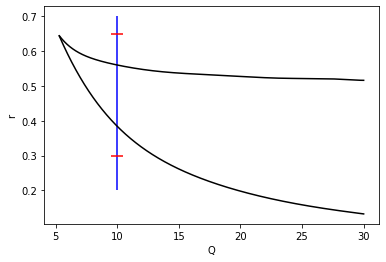

In [41]:
def determine_bifu_param_value_spruce(den=10000):
    
    params_upper = np.zeros((den, 3))
    u_upper = np.linspace(1.035, np.sqrt(3), den)
    for i, u in enumerate(u_upper):
        Q = 2*u**3/(u**2 - 1)
        r = 2*u**3/((1+u**2)**2)
        params_upper[i] = u, Q, r
    
    upper_fit = np.poly1d(np.polyfit(params_upper[:,1], params_upper[:,2], 8))
    
    params_lower = np.zeros((den, 3))
    u_lower = np.linspace(np.sqrt(3), np.sqrt(3)*9, den)
    for i, u in enumerate(u_lower):
        Q = 2*u**3/(u**2 - 1)
        r = 2*u**3/((1+u**2)**2)
        params_lower[i] = u, Q, r
    
    lower_fit = np.poly1d(np.polyfit(params_lower[:,1], params_lower[:,2], 6))
    
    Q_ = np.linspace(5.3, 30, den)
    params = np.zeros((den, 3))
    
    for i, Q in enumerate(Q_):
        params[i] = Q, lower_fit(Q), upper_fit(Q)
        
    fig, axis = plt.subplots(1, 1, figsize=(6,4))    
    
    axis.plot(Q_, params[:,1], "k")
    axis.plot(Q_, params[:,2], "k")
    
    axis.vlines(x=10, ymin=0.2, ymax=0.7, colors='b')
    
    axis.hlines(y=0.3, xmin=9.5, xmax=10.5, colors="r")
    axis.hlines(y=0.65, xmin=9.5, xmax=10.5, colors="r")

    axis.set_xlabel("Q")
    axis.set_ylabel("r")
    
    #fig.savefig(fname='../graphs/spruce_bistability_region.pdf', format='pdf')

    return params

_ = determine_bifu_param_value_spruce()

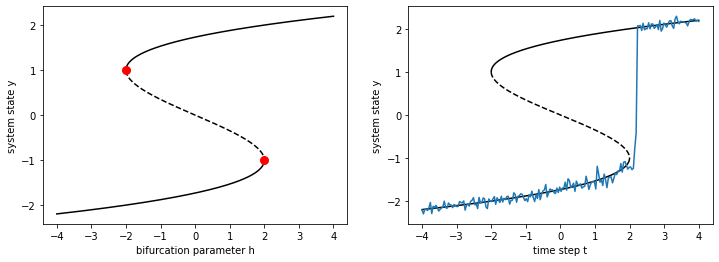

In [42]:
def bifurcation_normal_form(r=3, h_=np.linspace(-4,4,10000, endpoint=True)):
    lower_node = []
    saddle = []
    upper_node = []
    for h in h_:
        p = np.polynomial.Polynomial([h, r, 0, -1])
        roots = p.roots()[p.roots().imag == 0].real
        if len(roots) == 1:
            if roots[0] > 0:
                lower_node.append(np.nan)
                saddle.append(np.nan)
                upper_node.append(roots[0])
            else:
                lower_node.append(roots[0])
                saddle.append(np.nan)
                upper_node.append(np.nan)
        else:
            lower_node.append(roots[0])
            saddle.append(roots[1])
            upper_node.append(roots[2])
            
    fig, axis = plt.subplots(1, 2, figsize=(12,4))
            
    axis[0].plot(h_, lower_node, "k")
    axis[0].plot(h_, saddle, "k--")
    axis[0].plot(h_, upper_node, "k")
    
    axis[0].plot(2/3*r * np.sqrt(r/3), -1, "ro", markersize=8)
    axis[0].plot(-2/3*r * np.sqrt(r/3), 1, "ro", markersize=8)
    
    axis[0].set_xlabel("bifurcation parameter h")
    axis[0].set_ylabel("system state y")
    
    y_series = euler_maruyama(normal_form_saddle_node, y0=-2.2, dt=0.01, t_max=200, sd=0.3, ecological_boundary=False, early_stopping=False, h0=-4, hd=8/200, r=r)
    
    axis[1].plot(h_, lower_node, "k")
    axis[1].plot(h_, saddle, "k--")
    axis[1].plot(h_, upper_node, "k")
    
    axis[1].plot(np.linspace(-4, 4, 200, endpoint=True), y_series)
    axis[1].set_xlabel("time step t")
    axis[1].set_ylabel("system state y")
    
    #fig.savefig(fname='../graphs/normal_bifu.pdf', format='pdf')
    
        
bifurcation_normal_form()

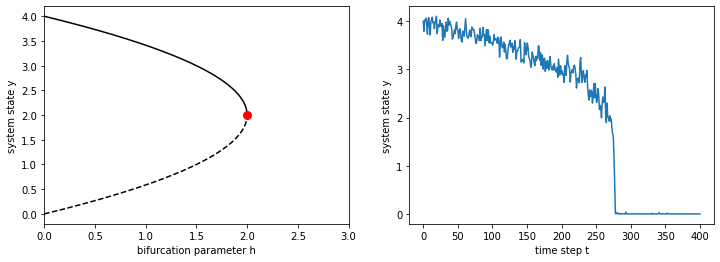

In [43]:
def bifurcation_constant_harvesting(r=2, K=4, h_=np.linspace(0,4,10000, endpoint=True)):
    stable = []
    unstable = []
    for h in h_:
        p = np.polynomial.Polynomial([-h, r, -r/K])
        roots = p.roots()[p.roots().imag == 0].real
        if len(roots) == 2:
            stable.append(roots[1])
            unstable.append(roots[0])
        else:
            stable.append(np.nan)
            unstable.append(np.nan)
            
    fig, axis = plt.subplots(1, 2, figsize=(12,4))
            
    axis[0].plot(h_, stable, "k")
    axis[0].plot(h_, unstable, "k--")
    
    axis[0].plot(2, 2, "ro", markersize=8)
    
    
    axis[0].set_xlabel("bifurcation parameter h")
    axis[0].set_ylabel("system state y")
    axis[0].set_xlim([0,3])
    
    y_series = euler_maruyama(constant_harvesting, y0=4, dt=0.01, t_max=400, sd=0.2, ecological_boundary=True, early_stopping=False, r=r, K=K, h0=0, hd=3/400)
    
    #axis[1].plot(h_, stable, "k")
    #axis[1].plot(h_, unstable, "k--")
    
    axis[1].plot(np.linspace(0, 400, 400, endpoint=True), y_series)
    axis[1].set_xlabel("time step t")
    axis[1].set_ylabel("system state y")
    
    #fig.savefig(fname='../graphs/constant_harvest_bifurcation_time_series.pdf', format='pdf')
    
        
bifurcation_constant_harvesting()

210


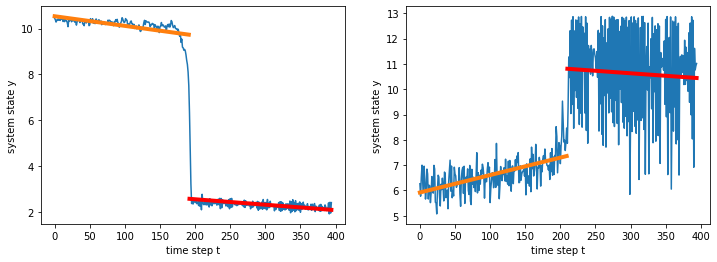

In [392]:
def visualize_linear_partitioning():
    
    fig, axis = plt.subplots(1, 2, figsize=(12,4))
    
    s = y_series_MHR[60]
    
    _, shift_loc = linear_partition(s, boundary=0.1)
    
    pre = s[:shift_loc]
    pre_X = np.reshape([x for x in range(0, len(pre))], (len(pre), 1))
    pre_fit = lr().fit(X=pre_X, y=pre)
    pre_pred = pre_fit.predict(pre_X)
    
    post = s[shift_loc:]
    post_X = np.reshape([x for x in range(shift_loc, shift_loc+len(post))], (len(post), 1))
    post_fit = lr().fit(X=post_X, y=post)
    post_pred = post_fit.predict(post_X)
    
    axis[0].plot(s)
    axis[0].plot(pre_X, pre_pred, lw=4)
    axis[0].plot(post_X, post_pred, lw=4, c='r')
    
    axis[0].set_xlabel("time step t")
    axis[0].set_ylabel("system state y")
    
    
    s = copy.deepcopy(y_series_MHR[185])
    
    s[:213] = s[:213] + 4 + np.random.normal(0, 0.5, size=213)
    
    _, shift_loc = linear_partition(s, boundary=0.1)
    print(shift_loc)
    pre = s[:shift_loc]
    pre_X = np.reshape([x for x in range(0, len(pre))], (len(pre), 1))
    pre_fit = lr().fit(X=pre_X, y=pre)
    pre_pred = pre_fit.predict(pre_X)
    
    post = s[shift_loc:]
    post_X = np.reshape([x for x in range(shift_loc, shift_loc+len(post))], (len(post), 1))
    post_fit = lr().fit(X=post_X, y=post)
    post_pred = post_fit.predict(post_X)
    
    axis[1].plot(s)
    axis[1].plot(pre_X, pre_pred, lw=4)
    axis[1].plot(post_X, post_pred, lw=4, c='r')
    
    axis[1].set_xlabel("time step t")
    axis[1].set_ylabel("system state y")
    
    #plt.savefig(fname='../graphs/linear_partitioning.pdf', format='pdf')
    
    
visualize_linear_partitioning()

In [ ]:
def visualize_series_dataset_transformation(s, shift_loc, shift_gap=3, input_window_size=20, transition_phase=30, saturation_phase=20, oversampling = False):

    plt.plot((s-min(s))/(max(s)-min(s)), label="time series")
    shift_loc = int(shift_loc)
    s = s[:shift_loc-shift_gap]
    
    #print(shift_loc, len(s))
    #plt.plot(s)
    
    n_windows = len(s) - input_window_size + 1
    
    #print(n_windows)
    
    while (n_windows < transition_phase + saturation_phase):
        transition_phase = max(transition_phase - 1, 2)
        saturation_phase = max(saturation_phase - 1, 2)
        print(saturation_phase, transition_phase)
        if transition_phase == 2:
            return None
        
        
    data = np.zeros((n_windows, input_window_size))
    for i in range(n_windows):
        data[i,:] = s[i:i+input_window_size]

    label = np.zeros((n_windows))
    label_transition = 1 / (1 + np.e**(0.5*30/transition_phase*(-np.linspace(0,transition_phase,transition_phase, endpoint=True)+transition_phase/2)))
    label[-transition_phase-saturation_phase+1:-saturation_phase+1] = label_transition
    if (saturation_phase > 0):
        label[-saturation_phase:] = 1
        
    plt.plot(range(input_window_size-1, input_window_size-1+n_windows), label, label="target label")
    
    dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(tf.convert_to_tensor(data), axis=2), tf.expand_dims(tf.convert_to_tensor(label), axis=1)))
    
    if oversampling:
        shift_data = data[label != 0]
        shift_label = label[label != 0]

        shift_len = transition_phase + saturation_phase
        no_shift_len = n_windows - shift_len

        while (len(shift_data) < no_shift_len - shift_len):
            shift_data = np.append(shift_data, data[label != 0], axis=0)
            shift_label = np.append(shift_label, label[label != 0], axis=0)

        shift_data = shift_data[:no_shift_len-shift_len]
        shift_label = shift_label[:no_shift_len-shift_len]

        dataset_to_balance_shift = tf.data.Dataset.from_tensor_slices((tf.expand_dims(tf.convert_to_tensor(shift_data), axis=2), tf.expand_dims(tf.convert_to_tensor(shift_label), axis=1)))
        dataset = dataset.concatenate(dataset_to_balance_shift)
    
    plt.hlines(y=0.5, xmin=0, xmax=input_window_size, colors="k")
    plt.vlines(x=input_window_size, ymin=label[0], ymax=0.5, colors="k", linestyles="dashed")
    
    plt.hlines(y=0.8, xmin=shift_loc-saturation_phase, xmax=shift_loc, colors="r", lw=5)
    plt.hlines(y=0.8, xmin=shift_loc-saturation_phase-transition_phase, xmax=shift_loc-saturation_phase, colors="y", lw=5)
    plt.hlines(y=0.8, xmin=input_window_size, xmax=shift_loc-saturation_phase-transition_phase, colors="g", lw=5)
    
    plt.legend()
    
    plt.xlabel("time step")
    plt.ylabel("label value")
    
    #plt.savefig(fname='../graphs/series_dataset_transformation.pdf', format='pdf')
    
    #plt.vlines(x=shift_loc, ymin=0, ymax=1, colors="k", lw=2)
    #plt.vlines(x=shift_loc-saturation_phase, ymin=0, ymax=1, colors="k", lw=2)
    #plt.vlines(x=shift_loc-saturation_phase-transition_phase, ymin=0, ymax=1, colors="k", lw=2)
    
    
    
    return dataset

n=7
visualize_series_dataset_transformation(y_series_normal[n], shift_loc_normal[n], shift_gap=1, transition_phase=50)

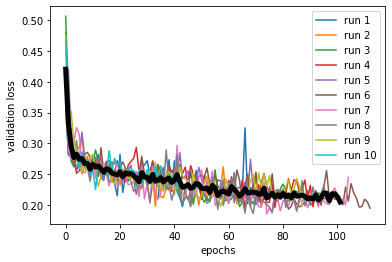

In [46]:
s = [pd.Series(history_i40[key]['val_loss'], name="run " + str(n+1)) for n, key in enumerate(history_i40)]

ax = pd.DataFrame(s).transpose().plot()
pd.DataFrame(s).transpose().mean(axis=1)[:102].plot(lw=5, c="k")

ax.set_xlabel("epochs")
ax.set_ylabel("validation loss")

#plt.savefig(fname='../graphs/training_performance.pdf', format='pdf')

0
1
2
a
3
4
5
6
7
8
9


([0.08266585196057956,
  0.22478285928567251,
  0.145404364913702,
  0.425982599457105,
  0.353134219845136,
  0.2991657555103302,
  0.18124914603928724,
  0.16330629835526148,
  0.890932540098826,
  0.3002302249272664],
 [0.269004687666893,
  0.7006649573644003,
  0.962675929069519,
  0.5200384060541788,
  0.8179125785827637,
  0.9406164288520813,
  0.5749092499415079,
  0.9514600038528442,
  0.993679404258728,
  0.6506609718004862])

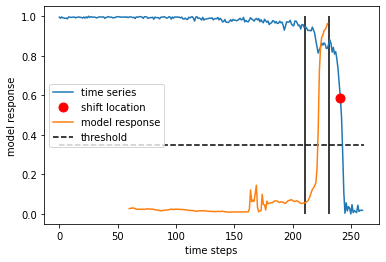

In [92]:
def visualize_model_response(models, input_window_sizes, timeseries, shift_loc, latest_detection_point=10, earliest_detection_point=30):
    no_shift_response = []
    shift_response = []
    
    for j, (s, s_loc) in enumerate(zip(timeseries, shift_loc)):
        print(j)
        
        s = normalize_series([s], [s_loc])[0]
        
        plot_index = 2
        
        s_loc = int(s_loc)
        
        if j == plot_index:
            plt.plot((s[:s_loc+20]-min(s[:s_loc+20]))/(max(s[:s_loc+20])-min(s[:s_loc+20])), label="time series")
            plt.vlines(x=s_loc-latest_detection_point, ymin=0, ymax=1, color='k')
            plt.plot(s_loc, (s[s_loc]-min(s[:s_loc+20]))/(max(s[:s_loc+20])-min(s[:s_loc+20])), "or", ms=9, label="shift location")
            plt.vlines(x=s_loc-earliest_detection_point, ymin=0, ymax=1, color='k')
            plt.hlines(y=0.35, xmin=0, xmax=s_loc+20, linestyles="dashed", color="k", label="threshold")
        
        s = s[:s_loc-latest_detection_point]
        
        model_pred = [[] for _ in range(len(models))]
        for n, model in enumerate(models):
            for i in range(0, len(s)):
                if i < input_window_sizes[n]:
                    model_pred[n].append(np.nan)
                else:
                    model_pred[n].append(np.array(model(s[i-input_window_sizes[n]:i].reshape((1, input_window_sizes[n], 1))))[0,0])
        
        model_pred_avg = np.mean(model_pred, axis=0)
        
        if j == plot_index:
            print("a")
            plt.plot(model_pred_avg, label="model response")
            plt.xlabel("time steps")
            plt.ylabel("model response")
            plt.legend()
            #plt.savefig(fname='../graphs/model_response.pdf', format='pdf')
        
        no_shift_response.append(np.nanmax(model_pred_avg[:-(earliest_detection_point-latest_detection_point)]))
        shift_response.append(np.nanmax(model_pred_avg[-(earliest_detection_point-latest_detection_point):]))
        
    return no_shift_response, shift_response
# 49
visualize_model_response([LSTM_model_i20, LSTM_model_i40, LSTM_model_i60], input_window_sizes=[20, 40, 60], timeseries=y_series_MHR_cleaned[50:60], shift_loc=shift_loc_MHR_c[50:60])
#visualize_model_response([LSTM_model_i20, LSTM_model_i40, LSTM_model_i60], input_window_sizes=[20, 40, 60], timeseries=y_series_MHR_cleaned[13:15], shift_loc=shift_loc_MHR_c[13:15])

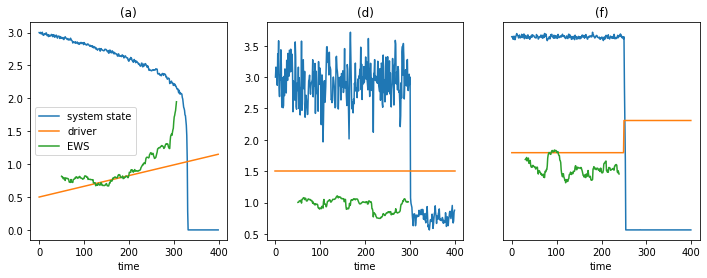

In [523]:
# simplified reproduction of figure 1 in Dakos2015
fig, axes = plt.subplots(1, 3, figsize=(12,4))

r=2
K=4
h_=np.linspace(0.5,1.15,400, endpoint=True)

y_series_a = euler_maruyama(constant_harvesting, y0=3, dt=0.01, t_max=400, sd=0.02, ecological_boundary=True, early_stopping=False, r=r, K=K, h0=1.5, hd=0.65/400)
sd, AR1 = CSD_indicators(y_series_a, 0.5*400/0.65, 50, 50, 0)

axes[0].plot(y_series_a, label='system state')
axes[0].plot(h_, label='driver')
axes[0].plot([s*13 for s in sd], label='EWS')
axes[0].legend()
axes[0].set_title('(a)')
axes[0].set_xlabel('time')


y_series_d = np.zeros((400))
y_series_d[:300] = euler_maruyama(constant_harvesting, y0=3, dt=0.01, t_max=300, sd=0.4, ecological_boundary=True, early_stopping=False, r=r, K=K, h0=1.5, hd=0)
y_series_d[-100:] = euler_maruyama(constant_harvesting, y0=3, dt=0.01, t_max=100, sd=0.1, ecological_boundary=True, early_stopping=False, r=r, K=K/3.5, h0=0.5, hd=0)
sd, AR1 = CSD_indicators(y_series_d, 0.5*400/0.65-10, 50, 50, 0)

axes[1].plot(y_series_d, label='system state')
axes[1].plot([1.5]*400, label='driver')
axes[1].plot([s*1 for s in sd], label='EWS')
#axes[1].legend()
axes[1].set_title('(d)')
axes[1].set_xlabel('time')


y_series_f = np.zeros((400))
y_series_f[:250] = euler_maruyama(constant_harvesting, y0=3, dt=0.01, t_max=250, sd=0.03, ecological_boundary=True, early_stopping=False, r=r, K=K, h0=1.5, hd=0)
y_series_f[-150:] = euler_maruyama(constant_harvesting, y0=3, dt=0.01, t_max=150, sd=0.1, ecological_boundary=True, early_stopping=False, r=r, K=K, h0=2.5, hd=0)
sd, AR1 = CSD_indicators(y_series_f, 250, 30, 50, 10)

axes[2].plot(y_series_f, label='system state')
axes[2].plot([1.2]*250 + [1.7]*150, label='driver')
axes[2].plot([s*1 for s in sd], label='EWS')
#axes[2].legend()
axes[2].set_title('(f)')
axes[2].set_xlabel('time')
axes[2].set(yticklabels=[])
axes[2].tick_params(left=False)
#plt.savefig(fname='../graphs/Dakos2015_figure1_5.pdf', format='pdf')

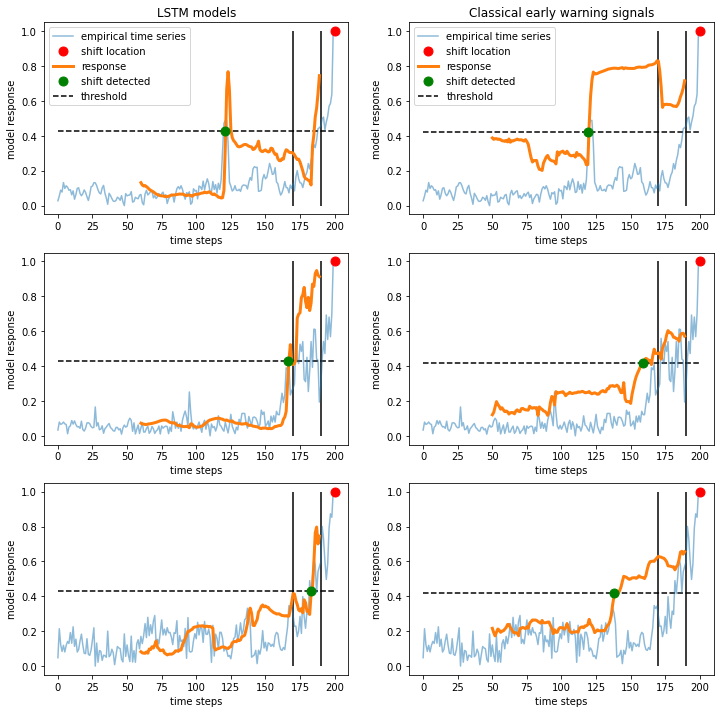

In [133]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))

def empi_ANN_plot(s, axis, info=False, threshold=0.43, models=[LSTM_model_i20, LSTM_model_i40, LSTM_model_i60], input_window_sizes=[20, 40, 60], latest_detection_point=10, earliest_detection_point=30, lgth=200):
    
    s_loc = len(s)
    s = normalize_series([s], [s_loc])[0]

    s_loc = s_loc-(len(s)-lgth)
    s = s[-lgth:]

    axis.plot((s-min(s))/(max(s)-min(s)), label="empirical time series", alpha=0.5)
    axis.vlines(x=s_loc-latest_detection_point, ymin=0, ymax=1, color='k')
    axis.plot(s_loc, (s[s_loc-1]-min(s))/(max(s)-min(s)), "or", ms=9, label="shift location")
    axis.vlines(x=s_loc-earliest_detection_point, ymin=0, ymax=1, color='k')
    axis.hlines(y=threshold, xmin=0, xmax=s_loc, linestyles="dashed", color="k", label="threshold")

    s = s[:s_loc-latest_detection_point]

    model_pred = [[] for _ in range(len(models))]
    for n, model in enumerate(models):
        for i in range(0, len(s)):
            if i < input_window_sizes[n]:
                model_pred[n].append(np.nan)
            else:
                model_pred[n].append(np.array(model(s[i-input_window_sizes[n]:i].reshape((1, input_window_sizes[n], 1))))[0,0])

    model_pred_avg = np.mean(model_pred, axis=0)
    
    detection = np.min(np.where(model_pred_avg > threshold))

    axis.plot(model_pred_avg, label="response", lw=3)
    axis.plot(detection-1, threshold, "og", ms=9, label="shift detected")
    axis.set_xlabel("time steps")
    axis.set_ylabel("model response")
    if info:
        axis.legend()
        axis.set_title('LSTM models')
    
def empi_CEWS_plot(s, axis, info=False, threshold=0.42, input_window_size=50, detrend_window=50, latest_detection_point=10, earliest_detection_point=30):
    
    s_loc = len(s)
    s = normalize_series([s], [s_loc])[0]

    s_loc = s_loc-(len(s)-lgth)
    s = s[-lgth:]

    axis.plot((s-min(s))/(max(s)-min(s)), label="empirical time series", alpha=0.5)
    axis.vlines(x=s_loc-latest_detection_point, ymin=0, ymax=1, color='k')
    axis.plot(s_loc, (s[s_loc-1]-min(s))/(max(s)-min(s)), "or", ms=9, label="shift location")
    axis.vlines(x=s_loc-earliest_detection_point, ymin=0, ymax=1, color='k')
    axis.hlines(y=threshold, xmin=0, xmax=s_loc, linestyles="dashed", color="k", label="threshold")
    
    s = s[:s_loc-latest_detection_point]
    s = detrend(s, detrend_window, center=True)
    
    sd = [np.nan] * input_window_size
    AR1 = [np.nan] * input_window_size
    
    for i in range(input_window_size, len(s)):
        sd.append(np.std(s[i-input_window_size:i]))
        AR1.append(abs(np.corrcoef(s[i-input_window_size:i], s[i-input_window_size+1:i+1])[0,1]))
    
    response = [(0.5*min(s,5)+0.5*a) for s,a in zip(sd, AR1)]
    
    detection = np.min(np.where(np.asarray(response) > threshold))
    
    axis.plot(response, label='response', lw=3)
    axis.plot(detection-1, threshold, "og", ms=9, label="shift detected")
    axis.set_xlabel("time steps")
    axis.set_ylabel("model response")
    if info:
        axis.legend()
        axis.set_title('Classical early warning signals')
        
#ids = rng.integers(low=0, high=len(empirical_timeseries_ending_shift)-1, size=3)
#ids = [6,1,2]
# ids = [21,8,2]
ids = [24,8,2]
    
empi_ANN_plot(s=empirical_timeseries_ending_shift[ids[0]], axis=axes[0,0], info=True)
empi_ANN_plot(s=empirical_timeseries_ending_shift[ids[1]], axis=axes[1,0])
empi_ANN_plot(s=empirical_timeseries_ending_shift[ids[2]], axis=axes[2,0])

empi_CEWS_plot(s=empirical_timeseries_ending_shift[ids[0]], axis=axes[0,1], info=True)
empi_CEWS_plot(s=empirical_timeseries_ending_shift[ids[1]], axis=axes[1,1])
empi_CEWS_plot(s=empirical_timeseries_ending_shift[ids[2]], axis=axes[2,1])

#plt.savefig(fname='../graphs/empirical_responses.pdf', format='pdf')

18 series have been removed. 482 well behaved series remaining.
219.00829875518673


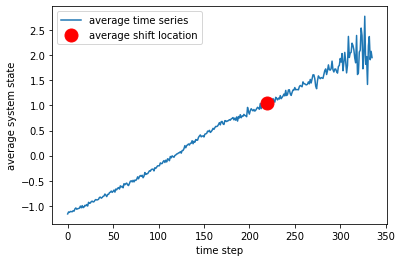

In [231]:
y_series_up_cleaned, shift_score_up_c, shift_loc_up_c = remove_outliers(y_series_normal[1::2], shift_score_normal[1::2], shift_loc_normal[1::2], 1, 0.15)
up = normalize_series(y_series_up_cleaned, shift_loc_up_c)

up = [u[:int(shift_loc_up_c[i])] for i,u in enumerate(up)]
print(np.mean(shift_loc_up_c))

#plt.plot(up[4])
pd.DataFrame([pd.Series(s) for s in up]).transpose()[:].mean(axis=1).plot(label='average time series')
plt.plot(np.mean(shift_loc_up_c), 1.05, 'ro', ms=13, label='average shift location')
plt.legend()
plt.xlabel('time step')
plt.ylabel('average system state')
#plt.savefig(fname='../graphs/average_trend_training_data.pdf', format='pdf')